In [1]:
import pandas as pd

df = pd.read_csv("Task 3 and 4_Loan_Data.csv")

df.head(), df.tail(), df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


(   customer_id  credit_lines_outstanding  loan_amt_outstanding  \
 0      8153374                         0           5221.545193   
 1      7442532                         5           1958.928726   
 2      2256073                         0           3363.009259   
 3      4885975                         0           4766.648001   
 4      4700614                         1           1345.827718   
 
    total_debt_outstanding       income  years_employed  fico_score  default  
 0             3915.471226  78039.38546               5         605        0  
 1             8228.752520  26648.43525               2         572        1  
 2             2027.830850  65866.71246               4         602        0  
 3             2501.730397  74356.88347               5         612        0  
 4             1768.826187  23448.32631               6         631        0  ,
       customer_id  credit_lines_outstanding  loan_amt_outstanding  \
 9995      3972488                         0       

In [2]:
from sklearn.model_selection import train_test_split

# Features (drop customer_id and target)
X = df.drop(columns=["customer_id", "default"])
y = df["default"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((7500, 6), (2500, 6), np.float64(0.18506666666666666), np.float64(0.1852))

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Build pipeline: scale → logistic regression
pd_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

# Train model
pd_model.fit(X_train, y_train)

print("Model training complete")


Model training complete


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predictions
y_pred = pd_model.predict(X_test)
y_prob = pd_model.predict_proba(X_test)[:, 1]  # probabilities of default

# Accuracy
acc = accuracy_score(y_test, y_pred)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(acc, 4))
print("ROC AUC:", round(roc_auc, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
confusion_matrix(y_test, y_pred)


Accuracy: 0.9984
ROC AUC: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2037
           1       1.00      0.99      1.00       463

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



array([[2037,    0],
       [   4,  459]])

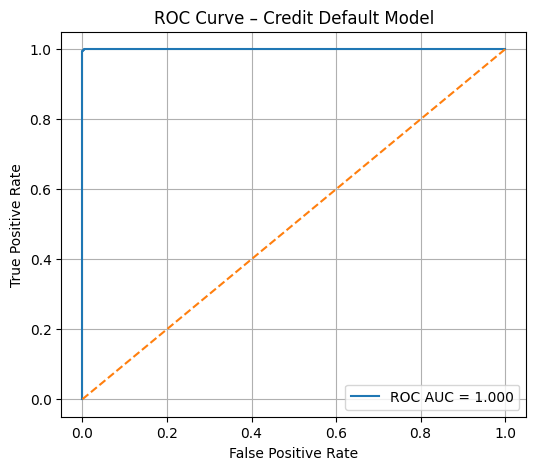

In [5]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Default Model")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
LGD = 0.9  # since recovery rate is 10%

def estimate_expected_loss(borrower_features, loan_amount):
    """
    borrower_features: list or array in this order:
    [credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding,
     income, years_employed, fico_score]

    loan_amount: float (exposure at default)

    returns: probability of default, expected loss
    """

    # convert to DataFrame with correct columns
    input_df = pd.DataFrame([borrower_features], columns=X.columns)

    # predict probability of default
    pd_value = pd_model.predict_proba(input_df)[0][1]

    # expected loss
    expected_loss = pd_value * loan_amount * LGD

    return pd_value, expected_loss


In [8]:
sample = X_test.iloc[0]
loan_amt = sample["loan_amt_outstanding"]

pd_val, exp_loss = estimate_expected_loss(sample.values, loan_amt)

print("Predicted PD:", round(pd_val, 4))
print("Loan Amount:", round(loan_amt, 2))
print("Expected Loss:", round(exp_loss, 2))


Predicted PD: 0.0
Loan Amount: 3832.91
Expected Loss: 0.0
